# Exercise 2: Data linkage

In this exercise we want to evaluate the impact of duplicated patients in a dataset. To address this issue, linkage algorithms may be used to merge records related to the same patients. They are commonly divided in **deterministic linkage** algorithms and in **probabilistic linkage** algorithms. Whereas deterministic algorithms rely on simple rules to match identifiers, probabilistic algorithms compute a similarity metric between pairs of records. A table of deduplicated patient identifiers is provided for examples of these two algorithms.

In this exercice, we will : 
1. Deduplicate the dataset by using a deterministic algorithm
2. Deduplicate the dataset by using a probabilistic algorithm
3. Compare the Kaplan-Meyer curves between these 2 groups and non deduplicated data from exercice 1.

We initialize the notebook by importing the following libraries:

In [79]:
import pandas as pd
import numpy as np

# Visualization library
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('default', max_rows=None)

# Dates management
import datetime

In [80]:
#Import the helper functions
import sys
sys.path.append("../")
sys.path.append("data/")
from viz import plot_primary_kaplan, plot_secondary_kaplan

# Table of content

# 1. Data Exploration


A fake dataset that mimics data coming from a clinical information system is made available in the */data* folder of this exercise.
<br>For this study, data has been extracted from the Clinical Data Warehouse on December 1st, 2025.
<br>The same data than in exercice 1 is imported

## 1.1 Data extracted from the Clinical Data Warehouse

Open the following files using the `pandas.read_pickle()` function : 
  - *data/df_person.pkl* as `df_person`
  - *data/df_visit.pkl* as `df_visit`
  - *data/df_condition.pkl* as `df_cond`
  - *data/df_med.pkl* as `df_med`


In [81]:
# Patients
df_person = pd.read_pickle("data/df_person.pkl")

# Visits
df_visit = pd.read_pickle("data/df_visit.pkl")

# Diagnosis (condition)
df_cond = pd.read_pickle("data/df_condition.pkl")

# Medication
df_med = pd.read_pickle("data/df_med.pkl")

In [82]:
df_person

,person_id,birth_datetime,death_datetime,gender_source_value,cdm_source
1012,81970282,1956-07-29,NaT,f,EHR 1
3508,87830669,1980-07-19,NaT,m,EHR 1
2132,89429283,1962-05-16,2020-06-14,m,EHR 1
363,82111706,1944-07-21,NaT,f,EHR 1
1058,81879940,1927-03-09,2022-10-11,f,EHR 1
...,...,...,...,...,...
8,86140106,1958-11-05,2022-03-31,f,EHR 1
382,86585517,2018-12-04,2019-12-13,m,EHR 1
2834,85715060,1975-03-14,NaT,f,EHR 1
3180,80359433,1968-08-17,NaT,m,EHR 1


## 1.2 Data provided by the deterministic deduplication algorithm

The results of the **deterministic algorithm** are made available in the *df_dedup_det* dataframe.

- Open the *data/df_dedup_deterministic.pkl* file as `df_dedup_det` using the `pandas.read_pickle()` function.
- Explore the type of each feature of the df_dedup_det DataFrame with the `.info()` function.
- Check out the first rows of the DataFrame using the `.head()` function.


In [83]:
df_dedup_det = pd.read_pickle('data/df_dedup_deterministic.pkl')
df_dedup_det
df_dedup_det.info()
df_dedup_det.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2031 entries, 2855 to 321
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   unique_person_id  2031 non-null   int64 
 1   person_id         2031 non-null   object
dtypes: int64(1), object(1)
memory usage: 47.6+ KB


,unique_person_id,person_id
2855,80808302,83057738
2808,81747693,87993293
1430,87991514,88170904
1433,86660301,85470579
740,84843798,85464125


In [85]:
df_dedup_det['person_id'] = df_dedup_det['person_id'].astype('Int64')

<br> The dataframe `df_dedup_det` is composed of 2 columns :
- *unique_person_id* : this id is the *real* id for the patient
- *person_id* : this id is another one, created by mistake

## 1.3 Data provided by the probabilistic deduplication algorithm

The results of the **probabilistic algorithm** are made available in the *df_dedup_proba* dataframe.

- Open the *data/df_dedup_proba.pkl* file as `df_dedup_proba` using the `pandas.read_pickle()` function.
- Explore the type of each feature of the df_dedup_proba DataFrame with the `.info()` function.
- Check out the first rows of the DataFrame using the `.head()` function.


In [40]:
df_dedup_proba = pd.read_pickle("data/df_dedup_proba.pkl")
df_dedup_proba.info()
df_dedup_proba.head()

<class 'pandas.core.frame.DataFrame'>
Index: 9445 entries, 81 to 975
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   unique_person_id  9445 non-null   int64  
 1   person_id         9445 non-null   object 
 2   prob              9445 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 295.2+ KB


,unique_person_id,person_id,prob
81,85833537,88898325,0.825227
436,81879765,81879765,0.177655
554,86445696,86257687,0.311453
366,82207130,80846980,1.000000
746,82467500,88763960,0.597121


In [86]:
df_dedup_proba['person_id'] = df_dedup_proba['person_id'].astype('Int64')

<br> The dataframe `df_dedup_proba` is composed of 3 columns :
- *unique_person_id* : this id is the *real* id for the patient
- *person_id* : this id is another one, created by mistake
- *prob* : the probability that the 2 these 2 ids are actually the same person

# 2. Preprocessing

## 2.1 Deduplicating using the deterministic algorithm


<br> The dataframe `df_dedup_det` is composed of 2 columns :
- *unique_person_id* : this id is the *real* id for the patient
- *person_id* : this id is another one, created by mistake

We are going to clean the `df_person` dataframe by only keeping a single id per patient.
- Create a dataframe `df_person_dedup_det` from `df_person` that contains 1 row per patient.

TIPS : 
- Outer join `df_person` and `df_dedup_det` on *person_id* using the `pandas.merge()` function (see [doc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html))
- Fill in the *unique_person_id* column with the *person_id* column when empty using the `pandas.fillna()` function (see [doc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html))
- If several rows have the same *unique_person_id*, only keep the first one using `pandas.drop_duplicates()` (see [doc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html))

In [87]:
# Merge df_person with df_dedup_det on 'person_id' using a left join
df_person_dedup_det = df_person.merge(
    df_dedup_det,
    on='person_id',
    how='outer'
)

# Create the new 'unique_person_id' column
# If 'unique_person_id' from df_dedup_det is NaN, fill it with 'person_id' from df_person
df_person_dedup_det['unique_person_id'] = df_person_dedup_det['unique_person_id'].fillna(df_person_dedup_det['person_id'])
df_person_dedup_det.drop_duplicates(subset=['unique_person_id'], inplace=True)

C:\Users\4240737\AppData\Local\Temp\ipykernel_11260\713715321.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_person_dedup_det['unique_person_id'] = df_person_dedup_det['unique_person_id'].fillna(df_person_dedup_det['person_id'])


In [88]:
for col in ['person_id', 'unique_person_id']:
    df_person_dedup_det[col] = pd.to_numeric(df_person_dedup_det[col], errors='coerce').astype('Int64')

df_person_dedup_det.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64737 entries, 0 to 66767
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   person_id            64737 non-null  Int64         
 1   birth_datetime       64737 non-null  datetime64[ns]
 2   death_datetime       30681 non-null  datetime64[ns]
 3   gender_source_value  64737 non-null  object        
 4   cdm_source           64737 non-null  object        
 5   unique_person_id     64737 non-null  Int64         
dtypes: Int64(2), datetime64[ns](2), object(2)
memory usage: 3.6+ MB


How many patients have we left ?

In [89]:
print(f"We have {df_person_dedup_det.person_id.nunique()} unique patient ids in this dataset when using the determinist algorithm.")

We have 64737 unique patient ids in this dataset when using the determinist algorithm.


## 2.2 Deduplicatng using probabilistic algorithm

<br> The dataframe `df_dedup_proba` is composed of 3 columns :
- *unique_person_id* : this id is the *real* id for the patient
- *person_id* : this id is another one, created by mistake
- *prob* : the probability that the 2 these 2 ids are actually the same person

Observe the distribution of the probabilities using `pandas.describe()` function

In [90]:
df_dedup_proba.describe()

,unique_person_id,person_id,prob
count,9.445000e+03,9445.0,9445.000000
mean,8.499789e+07,85013029.326522,0.577710
std,2.908403e+06,2891909.449076,0.389554
min,8.000051e+07,80000022.0,0.000023
25%,8.243744e+07,82492505.0,0.156758
50%,8.502407e+07,85025165.0,0.657442
75%,8.751843e+07,87531842.0,0.982158
max,8.999981e+07,89999726.0,1.000000


In [91]:
for col in ['person_id', 'unique_person_id']:
    df_dedup_proba[col] = pd.to_numeric(df_dedup_proba[col], errors='coerce').astype('Int64')

df_dedup_proba.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9445 entries, 81 to 975
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   unique_person_id  9445 non-null   Int64  
 1   person_id         9445 non-null   Int64  
 2   prob              9445 non-null   float64
dtypes: Int64(2), float64(1)
memory usage: 313.6 KB


Plot the estimated density of the distribution of the probabilities using `pandas.plot.density()` (see [doc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.density.html))

<Axes: ylabel='Density'>

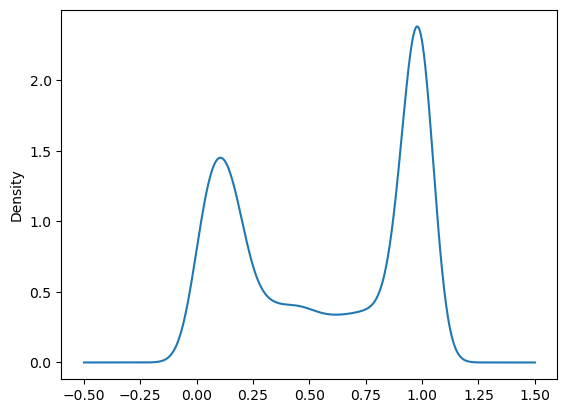

In [92]:
df_dedup_proba['prob'].plot.density()

**QUESTION**
Pourquoi des valeurs avant 0 et après 1 ?

Why is there a peak at probability = 1?

Create a function `deduplicate_proba(df_person: pd.DataFrame, df_dedup_proba: pd.DataFrame, score: int)` that returns a dataset of deduplicated person ids if their similarity score was above `score`.

TIPS : 
- Create a subset dataframe `df_dedup_proba_score` of df_person_dedup_proba keeping only rows where `'prob' > score`
- Outer join `df_person` and `df_dedup_proba_score` on *person_id* using the `pandas.merge()` function (see [doc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html))
- Fill in the *unique_person_id* column with the *person_id* column when empty using the `pandas.fillna()` function (see [doc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html))
- If several rows have the same *unique_person_id*, only keep the first one using `pandas.drop_duplicates()` (see [doc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html))

In [103]:
def deduplicate_proba(df_person: pd.DataFrame, df_dedup_proba: pd.DataFrame, score):
    df_dedup_proba_score = df_dedup_proba.loc[df_dedup_proba.prob > score]
    df_person_dedup_proba = df_person.merge(df_dedup_proba_score, on='person_id', how='outer')
    df_person_dedup_proba['unique_person_id'] = df_person_dedup_proba['unique_person_id'].fillna(df_person_dedup_proba['person_id'])
    df_person_dedup_proba.drop_duplicates(subset=['unique_person_id'], inplace=True)
    return df_person_dedup_proba

df_person_dedup_proba_90 = deduplicate_proba(df_person, df_dedup_proba,0.1)

Create a dataframe `df_person_dedup_proba_90` that only keeps the similarity scores above 0.90.<br>
How many patients do we have if the similarity score must be above 0.90 ?

In [ ]:
df_person_dedup_proba_90 = deduplicate_proba(df_person, df_dedup_proba, 1.0)
print(f"We have {len(df_person_dedup_proba_90)} unique patient ids in this dataset when using the probabilistic algorithm and a threshold of 0.90.")

We have 66768 unique patient ids in this dataset when using the probabilistic algorithm and a threshold of 0.90.


Create a dataframe `df_person_dedup_proba_20` that only keeps the similarity scores above 0.20.<br>
How many patients do we have if the similarity score must be above 0.20 ?

In [ ]:
df_person_dedup_proba_20 = #TODO
print(f"We have {#TODO} unique patient ids in this dataset when using the probabilistic algorithm and a threshold of 0.20.")

We can see that most linked records feature a high similarity score, but a significant amount of additional records would be matched by setting a low threshold. Let's compare two strategies for threshold setting, a high threshold strategy (*i.e.* keeping only high-confidence linkages, but missing some records that should be matched) and a low threshold strategy (*i.e.* linking most records that feature some similarities, among which some linkages correspond actually to different visits). 
<br>We choose as thresholds the values **0.9** and **0.2** to compare the consequences of both thresholds.

# 3. Statistical analysis

Now that we have deduplicated patient ids,  we can conduct the statistical analysis showing the impact of the deduplication process. 
<br>We plot the Kaplan-Meier estimates of survival curves, and realize the log-rank tests.
<br> The same functions `plot_primary_kaplan` used in the previous notebook can be used to plot the curves.
<br> If needed, you can print the docstrings using `print(plot_primary_kaplan.__doc__)`.

For this exercise, we have only kept the visits regarding the epidemic conditions. `df_visit` and `df_med` can be used to without any preprocessing.

In [30]:
t_end_of_study = datetime.date(2025,12,1)

In [31]:
 #Import the helper functions
import sys
sys.path.append("../")
from viz import plot_primary_kaplan, plot_secondary_kaplan

In [32]:
print(plot_primary_kaplan.__doc__)


Function that displays survival curves computed by the KaplanMeierFitter function from the lifeline package. 
It compares the drugA and drugB effects to the control cohort.

Parameters
----------
:param df_person_kaplan: pandas df,
    DataFrame gathering the demographic data about the patients of interest.
    Must have the same structure as the initial `df_person` table (must contain especially `person_id`
    and potential `death_datetime`).
:param list_case: list of tuples,
    List of studied case for the survival analysis.
    List of tuple (df_visit-pandas df-, df_med-pandas df-, name-str-) having :
        - df_visit : hospitalization DataFrame, with information on entry/exit dates
        - df_med : drug administration DataFrame, must contain ONLY the drugs of interest (i.e epidemic)
        - name : name of the studied case (for visualization purposes)
:param t_end_of_study: datetime.date,
    Date of the end of the study, i.e after which no information can be trusted (censo

## 3.1 Without deduplicating the person dataset

Plot the  primary Kaplan-Meier estimates for the whole `df_person` DataFrame

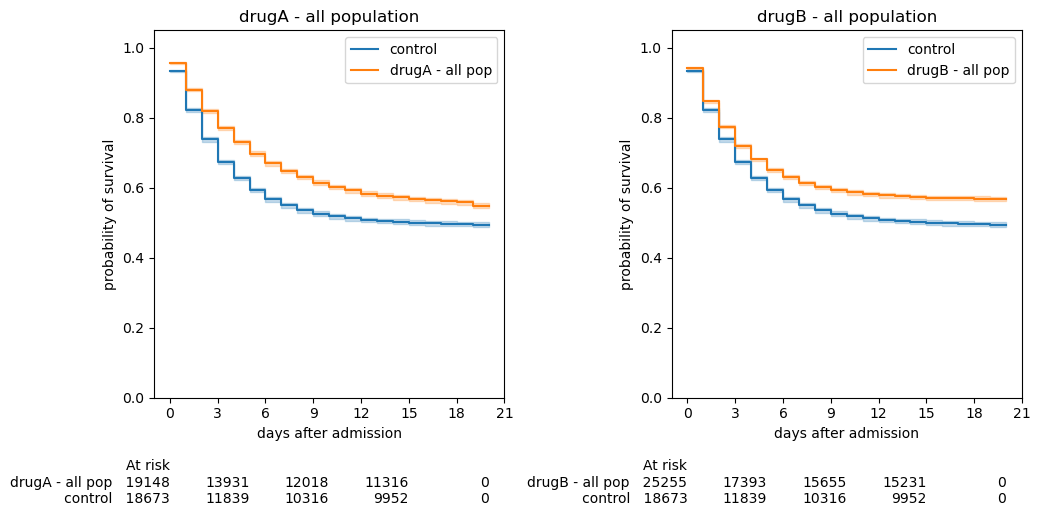

In [140]:
plot_primary_kaplan(df_person,[(df_visit,df_med,"all pop")],t_end_of_study)

What can be concluded on the effect of each drugs?

## 3.2 Using the determinist deduplication

Plot the  primary Kaplan-Meier estimates for the whole `df_person_dedup_det` dataFrame

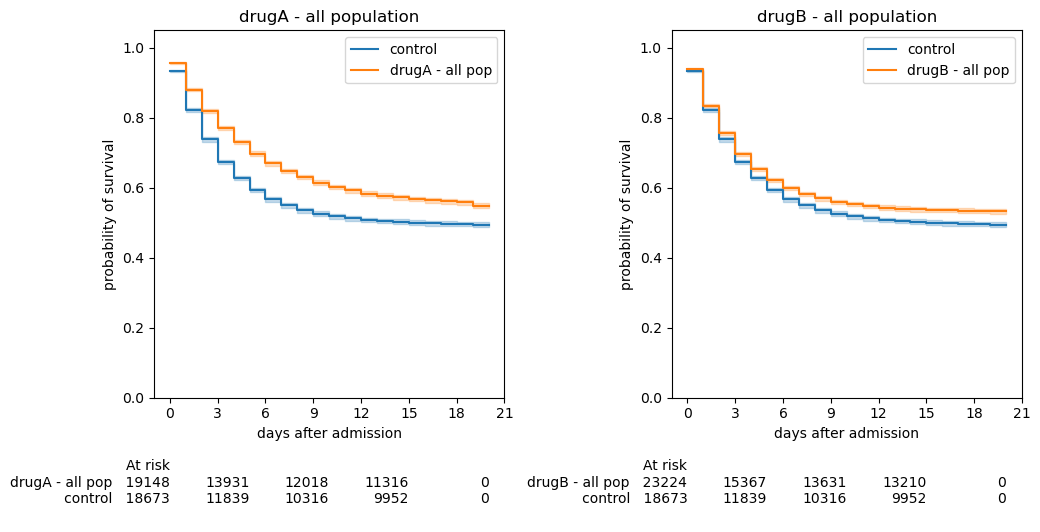

In [141]:
plot_primary_kaplan(df_person_dedup_det,[(df_visit,df_med,"all pop")],t_end_of_study)

What can be concluded on the effect of each drugs?

## 3.2 Using the probabilistic deduplication

Plot the  primary Kaplan-Meier estimates for the whole `df_person_dedup_proba_90` dataFrame

In [ ]:
#TODO

What can be concluded on the effect of each drugs?

Plot the  primary Kaplan-Meier estimates for the whole `df_person_dedup_proba_20` dataFrame

In [ ]:
#TODO

The survival curves obtained with the low value threshold diverge strongly from the high value threshold or from the survival curves computed using the deterministic algorithm. Our confidence in the low value threshold is therefore low, but we should keep investigating this issue, for instance realizing a validation of the probabilistic linkage by a chart review campaign.

In this exercise, we have shown some challenges related to the linkage of records in a clinical data warehouse. Various strategies may be adopted, and this methodological choice once more impacts the final results. 

# 4. Takeaways

- Clinical data warehouses contain **data collected in various clinical softwares** that may not always share **common identifiers**.
- It appears necessary to **link data coming from different softwares** prior to they statistical analysis (linkage to a common identity, to a visit occurrence, etc.). Linkage may rely on common identifiers or on more involved linkage algorithms.
- Linkage algorithms are commonly divided in **deterministic linkage** algorithms and in **probabilistic linkage** algorithms. Whereas deterministic algorithms rely on simple rules to match identifiers, probabilistic algorithms compute a similarity metric between pairs of records.
- Methodological choices related to data linkage may impact the result of the overall analysis

# 5. References

- Harron, Katie, Harvey Goldstein, et Chris Dibben. Methodological Developments in Data Linkage. Wiley Series in Probability and Statistics. Wiley, 2016.
- Harron, Katie, Angie Wade, Ruth Gilbert, Berit Muller-Pebody, et Harvey Goldstein. « Evaluating Bias Due to Data Linkage Error in Electronic Healthcare Records ». BMC Medical Research Methodology 14, nᵒ 1 (décembre 2014): 36. https://doi.org/10.1186/1471-2288-14-36.
- Gilbert, Ruth, Rosemary Lafferty, Gareth Hagger-Johnson, Katie Harron, Li-Chun Zhang, Peter Smith, Chris Dibben, et Harvey Goldstein. « GUILD: GUidance for Information about Linking Data Sets† ». Journal of Public Health 40, nᵒ 1 (1 mars 2018): 191‑98. https://doi.org/10.1093/pubmed/fdx037.
- Vatsalan, Dinusha, Peter Christen, et Vassilios S. Verykios. « A Taxonomy of Privacy-Preserving Record Linkage Techniques ». Information Systems 38, nᵒ 6 (septembre 2013): 946‑69. https://doi.org/10.1016/j.is.2012.11.005.